Zmierz się z problemem identyfikacji rodzaju szkła. W tym celu wykorzystaj jeden ze zbiorów danych
UCI - GLASS. Zadania powinny być wykonane z pomocą Pythona i/lub WEKI. Punktacja:
1. eksploracja danych – przedstaw podstawowe dane statystyczne i uwagi dotyczące cech i etykiet
zbioru danych. (10 punktów)
2. przygotowanie danych – podziel dane na zestaw uczący i walidacyjny (alternatywnie użyj walidacji krzyżowej), zbadaj wpływ różnego typu przetworzenia danych na wyniki klasyfikacji (proponowane: normalizacja, standaryzacja, dyskretyzacja, selekcja cech, PCA) - czyli wykonaj porównanie wyników bez przetworzenia danych z rezultatami po ich przetworzeniu, wykorzystując
co najmniej 2 metody różnego typu (osobno). (30 punktów)
Bonus – usuń 5% wartości cech i przygotuj dane stosując metody radzenia sobie z brakującymi
danymi. (5 punktów)
3. klasyfikacja – przetestuj klasyfikatory i zbadaj wpływ na wyniki: naiwny klasyfikator Bayesa oraz
drzewo decyzjne używając przynajmniej 3 różnych zestawów hiperparametrów. (40 punktów)
Bonus – Przetestuj (ze zrozumieniem!) bardziej zaawansowane algorytmy, takie jak Las losowy
czy Klasyfikator wektorów nośnych (SVM, z ang. Support Vector Machines). (5 punktów)
4. ocena klasyfikacji – do porównania wyników różnego typu przygotowania danych oraz wykorzystanego klasyfikatora użyj poznanych metryk oceny klasyfikacji i zinterpretuj wyniki. (20
punktów)
4
Do zadania przygotuj raport zawierający krótki opis wszystkich wykonywanych kroków oraz rezultatów zadania (najlepiej zebranych tabeli) wraz z interpretacją. W raporcie wskaż wykorzystane
materiały źródłowe oraz krótko opisz biblioteki wykorzystane przy implementacji. Raport wyślij prowadzącemu przynajmniej na 24 godziny przed oddaniem listy.


Importowanie danych

In [ ]:
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
# downolad and save csv file
column_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
if 'glass_data.csv' in os.listdir(): # check if file exists in current directory if not download it
    glass_data = pd.read_csv('glass_data.csv')
else:
    glass_data = pd.read_csv(data_url, names=column_names)
    glass_data.to_csv('glass_data.csv', index=False)


print(glass_data.head(20))

d number: od 1 do 214 (usunięte z pliku CSV)

RI: współczynnik załamania światła
Na: Sód (jednostka miary: procent wagowy w odpowiednim tlenku, podobnie jak atrybuty 4-10)
Mg: Magnez
Al: aluminium
K: Potas
Ca: Wapń
Ba: Bar
Fe: Żelazo
Rodzaj szkła: (atrybut klasy) [1-7]
Building_windows_float_processed
Building_windows_non_float_processed
Vehicle_windows_float_processed
Vehicle_windows_non_float_processed
Pojemniki
Zastawa stołowa
Reflektory


eksploracja danych

In [ ]:
glass_data.shape

dataset ma 214 wierszy i 10 kolumn

In [ ]:
glass_data.isnull().sum()

dataset nie ma brakujących danych

In [ ]:
glass_data.info()

In [ ]:
glass_data.describe()

pokaz type

In [ ]:
print(glass_data['Type'].value_counts())

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.8)
plt.subplots(figsize = (15,8))
sns.countplot(x="Type", data=glass_data, palette="Set2")

wynioski z eksploracji danych:
Powyższe statystyki pokazują, że dane we wszystkich atrybutach nie są w tym samym zakresie, więc najpierw znormalizujemy dane

przygotowanie danych

Usuwanie niepotrzebnej kolumny Id

In [ ]:
glass_data.drop(['Id'], axis=1, inplace=True)
glass_data.head(3)

Odseparowanie kolumny klasy od reszty danych

In [ ]:
y = glass_data['Type']

X = glass_data.drop('Type', axis=1)

X.shape

In [ ]:
type(X)

In [ ]:
y.shape

Nasz wykres pokazuje korelację między różnymi cechami Wnioski:

RI i Ca mają silną korelację między sobą
AI i ba mają pośrednią korelację między sobą

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots(figsize = (20,15))
plt.subplot(3,3,1)
sns.boxplot(x='Type', y='RI', data=glass_data)
plt.subplot(3,3,2)
sns.boxplot(x='Type', y='Na', data=glass_data)
plt.subplot(3,3,3)
sns.boxplot(x='Type', y='Mg', data=glass_data)
plt.subplot(3,3,4)
sns.boxplot(x='Type', y='Al', data=glass_data)
plt.subplot(3,3,5)
sns.boxplot(x='Type', y='Si', data=glass_data)
plt.subplot(3,3,6)
sns.boxplot(x='Type', y='K', data=glass_data)
plt.subplot(3,3,7)
sns.boxplot(x='Type', y='Ca', data=glass_data)
plt.subplot(3,3,8)
sns.boxplot(x='Type', y='Ba', data=glass_data)
plt.subplot(3,3,9)
sns.boxplot(x='Type', y='Fe', data=glass_data)
plt.show()

Wykres pudełkowy pokazuje, że średni współczynnik załamania światła jest podobny dla wszystkich typów. Chociaż typ 5 ma szerszy zakres i nieco wyższą średnią. Zawartość sodu jest wyższa w typie 6 i 7, podczas gdy zawartość magnezu jest dość wysoka w typie 1, 2 i 3. Glin jest wyższy w typie 5 i 7. Krzemionka nie dostarcza wielu informacji do rozróżnienia, ponieważ ma najwyższe stężenie spośród wszystkich minerałów, ale ma podobny zakres dla wszystkich typów. Potas również nie zapewnia wiele wglądu. Ale jest wyższy w pojemnikach typu 5, ponieważ K jest używany w hartowanym szkle, które jest używane do wytwarzania przedmiotów pyrex. Wapń jest najwyższy w typie 5, a bar w typie 7. Żelazo występuje w bardzo niskim stężeniu, jednak typy 1, 2 i 3 mają wyższe wartości dla niektórych szkieł niż pozostałe. Dzieje się tak dlatego, że żelazo dodaje się głównie do kolorowych szkieł. Mamy pewien pomysł na to, która funkcja zapewnia lepszy wgląd w odróżnianie jednego typu od drugiego. Teraz zobaczmy związek między każdym z nich za pomocą wykresu pary. (Pominiemy K, Ba i Fe ze względu na rzadkie stężenie)

In [ ]:
correlation_matrix = X.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji cech')
plt.show()

Train Test Split Podział danych na zestaw uczący i walidacyjny


Najpierw zastosujemy model bez przetwarzania danych

In [ ]:
# show X distribution of values as a violin plot of each column show it using sublots in a loop
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots(figsize = (20,15))
for i, col in enumerate(X.columns):
    plt.subplot(3,3,i+1)
    sns.violinplot(x=col, data=X)



In [ ]:
# Normalizer
normalized_X = Normalizer().fit_transform(X)

normalized_X_DF = pd.DataFrame(normalized_X, columns=X.columns)

# show results as a violin plot of each column using sublots in a loop
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots(figsize = (20,15))
for i, col in enumerate(normalized_X_DF.columns):
    plt.subplot(3,3,i+1)
    sns.violinplot(x=col, data=normalized_X_DF)






In [ ]:
# standarize data and store it in standarized_X variable
standarized_X = StandardScaler().fit_transform(X)
# show first 5 rows of standarized_X
standarized_X_DF = pd.DataFrame(standarized_X, columns=X.columns)

#  i want to display histogram of eacy column in standarized_X_DF as a violin plot
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots(figsize = (20,15))
for i, col in enumerate(standarized_X_DF.columns):
    plt.subplot(3,3,i+1)
    sns.violinplot(x=col, data=standarized_X_DF)


In [ ]:
# use power transformation in yeo-johnson method and store it in transformed_X variable
from sklearn.preprocessing import PowerTransformer


transformed_X = PowerTransformer(method='yeo-johnson').fit_transform(X)
# show first 5 rows of transformed_X
transformed_X_DF = pd.DataFrame(transformed_X, columns=X.columns)

#  i want to display histogram of eacy column in transformed_X_DF as a violin plot
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots(figsize = (20,15))
for i, col in enumerate(transformed_X_DF.columns):
    plt.subplot(3,3,i+1)
    sns.violinplot(x=col, data=transformed_X_DF)

In [ ]:

# PCA - Principal Component Analysis - reduce dimensionality of data
# use PCA to reduce dimensionality of data of X 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
principal_DF = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_DF.head()

In [ ]:
# show PCA results as a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(principal_DF['PC1'], principal_DF['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

In [ ]:
# discrete data X to discrete_X
discrete_X = pd.DataFrame(pd.cut(X['RI'], bins=3, labels=[1, 2, 3]))
discrete_X.head()


zbadaj wpływ różnego typu przetworzenia danych na wyniki klasyfikacji (proponowane: normalizacja, standaryzacja, dyskretyzacja, selekcja cech, PCA) - czyli wykonaj porównanie wyników bez przetworzenia danych z rezultatami po ich przetworzeniu, wykorzystując
co najmniej 2 metody różnego typu (osobno). (30 punktów)

In [ ]:
# split data into train and vaildation sets for each of X and y sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train_norm, X_val_norm, y_train_norm, y_val_norm = train_test_split(normalized_X, y, test_size=0.3, random_state=0, stratify=y)

X_train_stand, X_val_stand, y_train_stand, y_val_stand = train_test_split(standarized_X, y, test_size=0.3, random_state=0, stratify=y)

X_train_transformed , X_val_transformed, y_train_transformed, y_val_transformed = train_test_split(transformed_X, y, test_size=0.3, random_state=0, stratify=y)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(principal_DF, y, test_size=0.3, random_state=0, stratify=y)


In [ ]:
## Flattening the array
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

y_train_norm = y_train_norm.values.ravel()
y_val_norm = y_val_norm.values.ravel()

y_train_stand = y_train_stand.values.ravel()
y_val_stand = y_val_stand.values.ravel()

y_train_pca = y_train_pca.values.ravel()
y_val_pca = y_val_pca.values.ravel()

y_train_transformed = y_train_transformed.values.ravel()
y_val_transformed = y_val_transformed.values.ravel()



In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:

# make a functiion that will train and test model as arguments it gest data and model and returns accuracy, precision, recall, f1
def train_and_test_model(X_train, X_val, y_train, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

# train and test model of naive bayes GaussianNB of each data, not processed, normalized, standarized, PCA, discrete


In [135]:

accuracy, precision, recall, f1 = train_and_test_model(X_train, X_val, y_train, y_val, GaussianNB())
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

accuracy_norm, precision_norm, recall_norm, f1_norm = train_and_test_model(X_train_norm, X_val_norm, y_train_norm, y_val_norm, GaussianNB())
print('Accuracy: ', accuracy_norm)
print('Precision: ', precision_norm)
print('Recall: ', recall_norm)
print('F1: ', f1_norm)

accuracy_stand, precision_stand, recall_stand, f1_stand = train_and_test_model(X_train_stand, X_val_stand, y_train_stand, y_val_stand, GaussianNB())
print('Accuracy: ', accuracy_stand)
print('Precision: ', precision_stand)
print('Recall: ', recall_stand)
print('F1: ', f1_stand)

accuracy_pca, precision_pca, recall_pca, f1_pca = train_and_test_model(X_train_pca, X_val_pca, y_train_pca, y_val_pca, GaussianNB())
print('Accuracy: ', accuracy_pca)
print('Precision: ', precision_pca)
print('Recall: ', recall_pca)
print('F1: ', f1_pca)

accuracy_transformed, precision_transformed, recall_transformed, f1_transformed = train_and_test_model(X_train_transformed, X_val_transformed, y_train_transformed, y_val_transformed, GaussianNB())
print('Accuracy: ', accuracy_transformed)
print('Precision: ', precision_transformed)
print('Recall: ', recall_transformed)
print('F1: ', f1_transformed)

# compare results of each data processing method in a table
results_nb = pd.DataFrame({'Accuracy': [accuracy, accuracy_norm, accuracy_stand, accuracy_pca, accuracy_transformed],
                        'Precision': [precision, precision_norm, precision_stand, precision_pca, precision_transformed],
                        'Recall': [recall, recall_norm, recall_stand, recall_pca, recall_transformed],
                        'F1': [f1, f1_norm, f1_stand, f1_pca, f1_transformed]},
                        index=['Not processed', 'Normalized', 'Standarized', 'PCA', 'Transformed'])
results_nb


Accuracy:  0.49230769230769234
Precision:  0.4326524352840142
Recall:  0.49230769230769234
F1:  0.41897958266164
Accuracy:  0.4307692307692308
Precision:  0.37133095662507426
Recall:  0.4307692307692308
F1:  0.38015484515484516
Accuracy:  0.49230769230769234
Precision:  0.4326524352840142
Recall:  0.49230769230769234
F1:  0.41897958266164
Accuracy:  0.4307692307692308
Precision:  0.389792899408284
Recall:  0.4307692307692308
F1:  0.3846254399195576
Accuracy:  0.4461538461538462
Precision:  0.44046082123005204
Recall:  0.4461538461538462
F1:  0.42726423902894484


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1
Not processed,0.492308,0.432652,0.492308,0.418980
Normalized,0.430769,0.371331,0.430769,0.380155
Standarized,0.492308,0.432652,0.492308,0.418980
PCA,0.430769,0.389793,0.430769,0.384625
Transformed,0.446154,0.440461,0.446154,0.427264


In [ ]:

# visualise it in a bar chart
results_nb.plot(kind='bar', figsize=(10, 8))
plt.title('GaussianNB')
plt.xlabel('Data processing method')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))



In [ ]:

accuracy, precision, recall, f1 = train_and_test_model(X_train, X_val, y_train, y_val, DecisionTreeClassifier(random_state=0))
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

accuracy_norm, precision_norm, recall_norm, f1_norm = train_and_test_model(X_train_norm, X_val_norm, y_train_norm, y_val_norm, DecisionTreeClassifier(random_state=0))
print('Accuracy: ', accuracy_norm)
print('Precision: ', precision_norm)
print('Recall: ', recall_norm)
print('F1: ', f1_norm)

accuracy_stand, precision_stand, recall_stand, f1_stand = train_and_test_model(X_train_stand, X_val_stand, y_train_stand, y_val_stand, DecisionTreeClassifier(random_state=0))
print('Accuracy: ', accuracy_stand)
print('Precision: ', precision_stand)
print('Recall: ', recall_stand)
print('F1: ', f1_stand)

accuracy_pca, precision_pca, recall_pca, f1_pca = train_and_test_model(X_train_pca, X_val_pca, y_train_pca, y_val_pca, DecisionTreeClassifier(random_state=0))
print('Accuracy: ', accuracy_pca)
print('Precision: ', precision_pca)
print('Recall: ', recall_pca)
print('F1: ', f1_pca)

accuracy_transformed, precision_transformed, recall_transformed, f1_transformed = train_and_test_model(X_train_transformed, X_val_transformed, y_train_transformed, y_val_transformed, DecisionTreeClassifier(random_state=0))
print('Accuracy: ', accuracy_transformed)
print('Precision: ', precision_transformed)
print('Recall: ', recall_transformed)
print('F1: ', f1_transformed)

# compare results of each data processing method in a table
results_dt = pd.DataFrame({'Accuracy': [accuracy, accuracy_norm, accuracy_stand, accuracy_pca, accuracy_transformed],
                        'Precision': [precision, precision_norm, precision_stand, precision_pca, precision_transformed],
                        'Recall': [recall, recall_norm, recall_stand, recall_pca, recall_transformed],
                        'F1': [f1, f1_norm, f1_stand, f1_pca, f1_transformed]},
                        index=['Not processed', 'Normalized', 'Standarized', 'PCA', 'Transformed'])
results_dt


In [ ]:

# visualise it in a bar chart
results_dt.plot(kind='bar', figsize=(10, 8))
plt.title('DecisionTreeClassifier')
plt.xlabel('Data processing method')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))


klasyfikacja – przetestuj klasyfikatory i zbadaj wpływ na wyniki: naiwny klasyfikator Bayesa oraz
drzewo decyzjne używając przynajmniej 3 różnych zestawów hiperparametrów. (40 punktów)
Bonus – Przetestuj (ze zrozumieniem!) bardziej zaawansowane algorytmy, takie jak Las losowy
czy Klasyfikator wektorów nośnych (SVM, z ang. Support Vector Machines). (5 punktów)

klasyfikacja – przetestuj klasyfikatory i zbadaj wpływ na wyniki: naiwny klasyfikator Bayesa oraz
drzewo decyzjne używając przynajmniej 3 różnych zestawów hiperparametrów. (40 punktów)



In [ ]:
def processing():
    return [('None', X_train, X_val, y_train, y_val),
        ('Normalizer', X_train_norm, X_val_norm, y_train_norm, y_val_norm),
        ('StandardScaler', X_train_stand, X_val_stand, y_train_stand, y_val_stand),
        ('PCA', X_train_pca, X_val_pca, y_train_pca, y_val_pca),
        ('Transformed', X_train_transformed, X_val_transformed, y_train_transformed, y_val_transformed)]

In [ ]:

def nb_classifiers_create(params):
    nb_params = params
    nb_classifiers = []
    
    for param in nb_params:
        nb = GaussianNB(var_smoothing=param)
        nb_classifiers.append(nb)

    return nb_classifiers

In [ ]:
np.logspace(0, -9, num=100)


In [ ]:
# create a function that will iterate of each classifier and show results
def iterate_classifiers(classifiers):

    for name, X_processed_train, X_processed_val, y_processed_train, y_processed_val in processing():
        results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'])
        index = 0
        best_iter = 0
        best_accuracy = 0
        for classifier in classifiers:
            accuracy, precision, recall, f1 = train_and_test_model(X_processed_train, X_processed_val, y_processed_train, y_processed_val, classifier)
            results.loc[classifier.__class__.__name__ + str(name) + ' ' +  str(index)] = [accuracy, precision, recall, f1]
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_iter = index
            index += 1
        print('Best iteration: ', best_iter)
        results.plot(kind='line', figsize=(10, 8))
        plt.xlabel('Classifier')
        plt.ylabel('Scores')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.0, 1.0))


Naive Bayes


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  11


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  10


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  9


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  10
Best iteration:  0


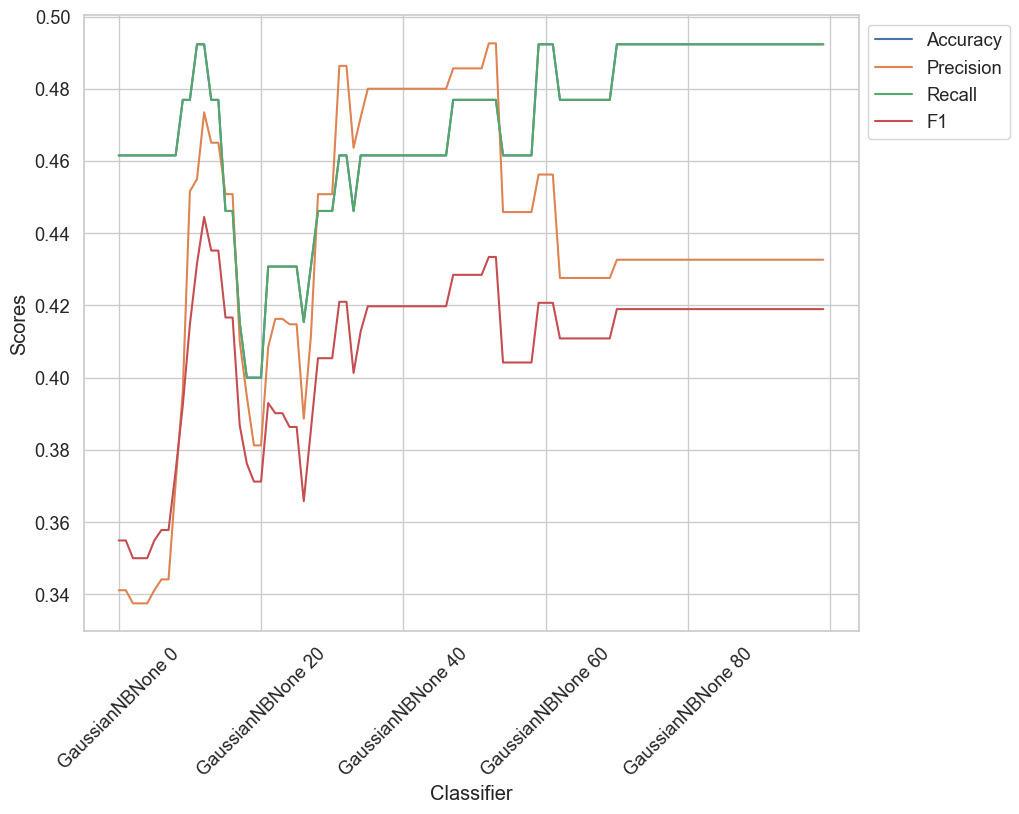

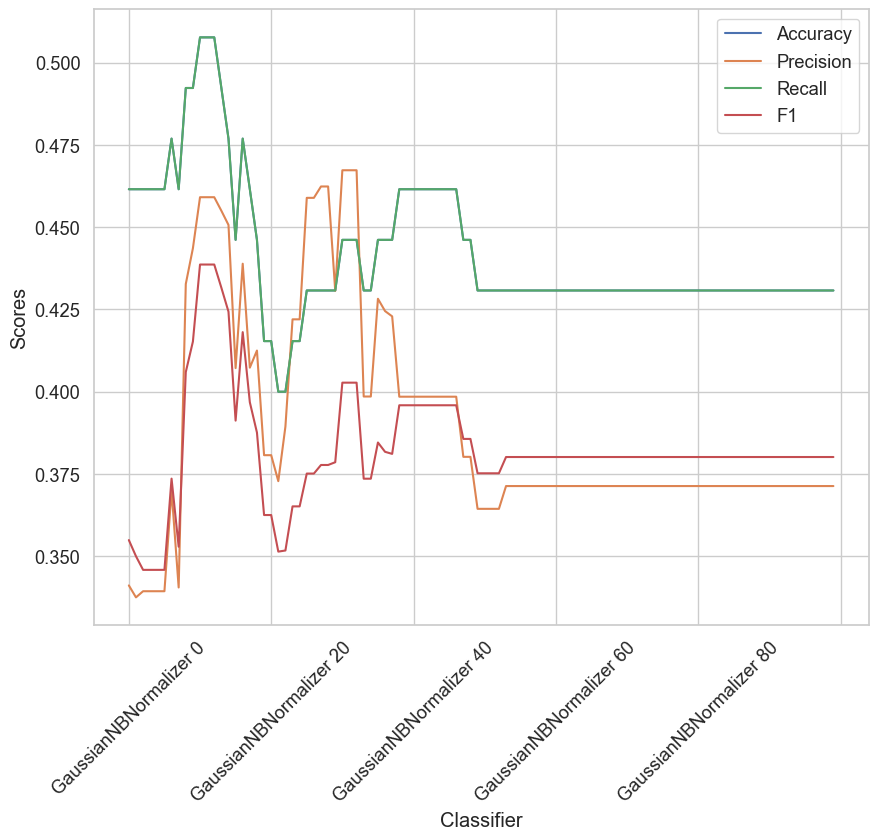

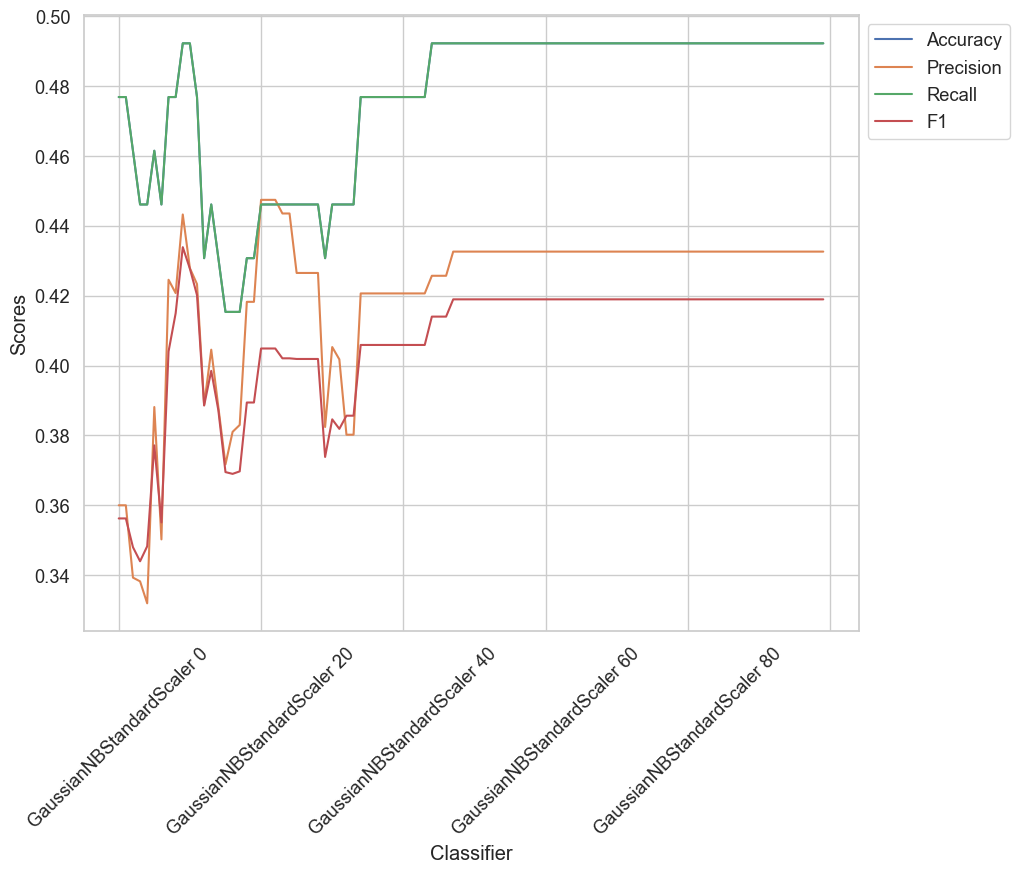

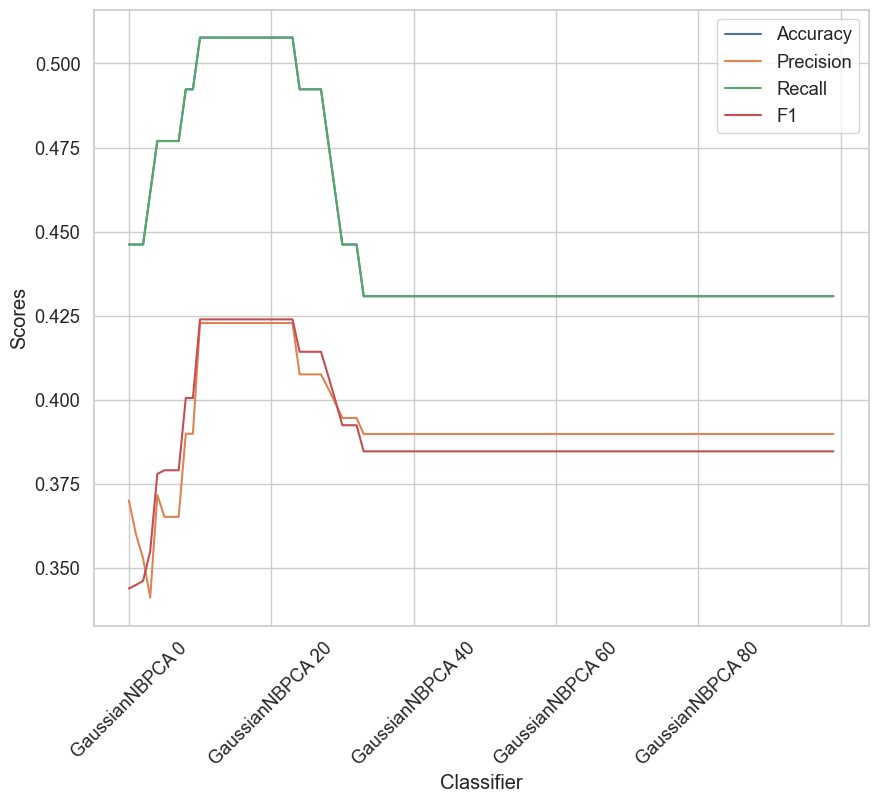

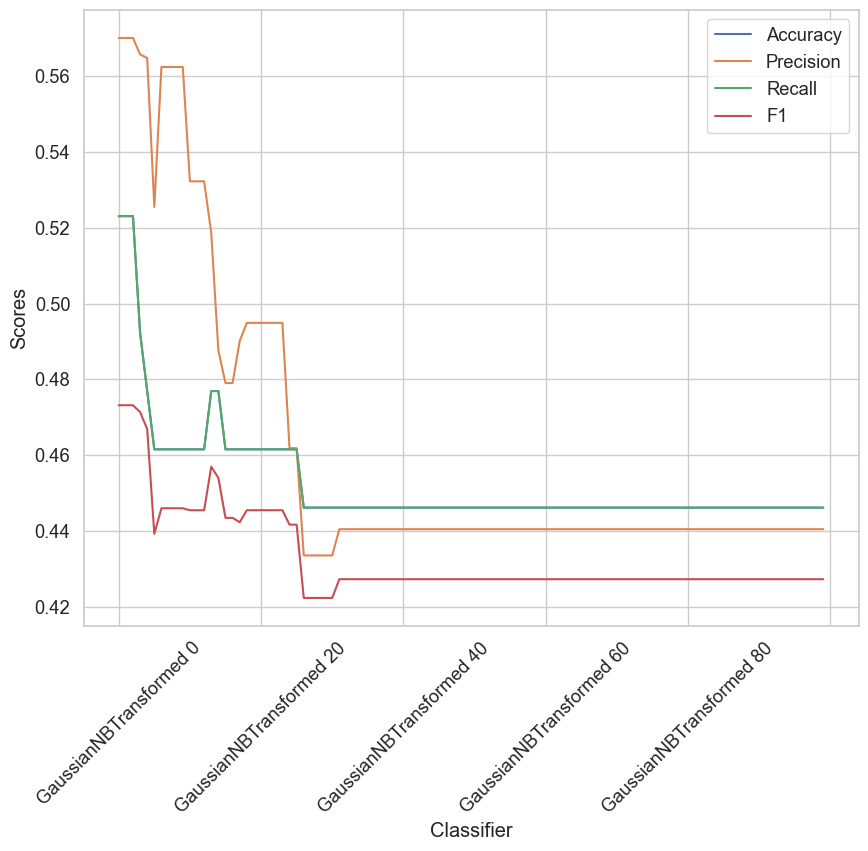

In [138]:
# iterate over NB classifiers
import numpy as np
nb_params = np.logspace(0, -9, num=100)
# get first 30 params
nb_classifiers = nb_classifiers_create(nb_params)
print('Naive Bayes')
iterate_classifiers(nb_classifiers)

In [ ]:
def dt_classifiers_create(dt_params):
    dt_classifiers = []
    for params in dt_params:
        dt = DecisionTreeClassifier(criterion=params.get('criterion'), max_depth=params.get('max_depth'),
                                    min_samples_split=params.get('min_samples_split'), random_state=0)
        dt_classifiers.append(dt)

    return dt_classifiers


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  2
Best iteration:  2
Best iteration:  2


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  3
Best iteration:  2


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

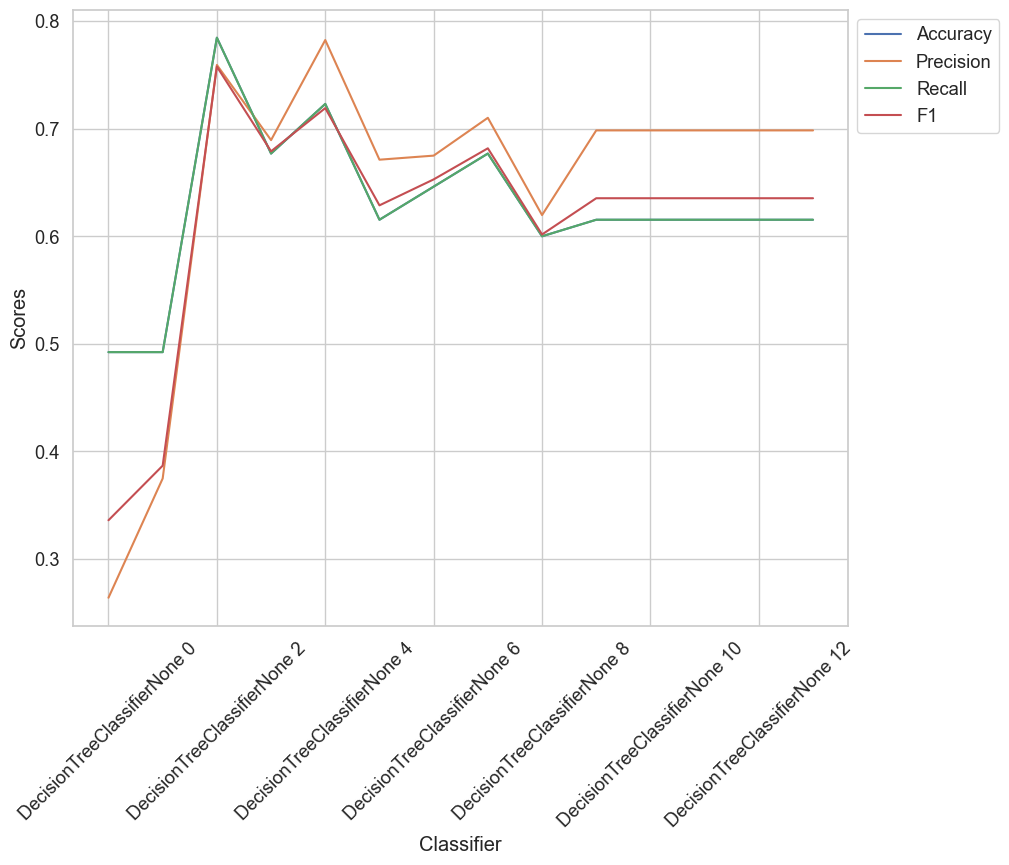

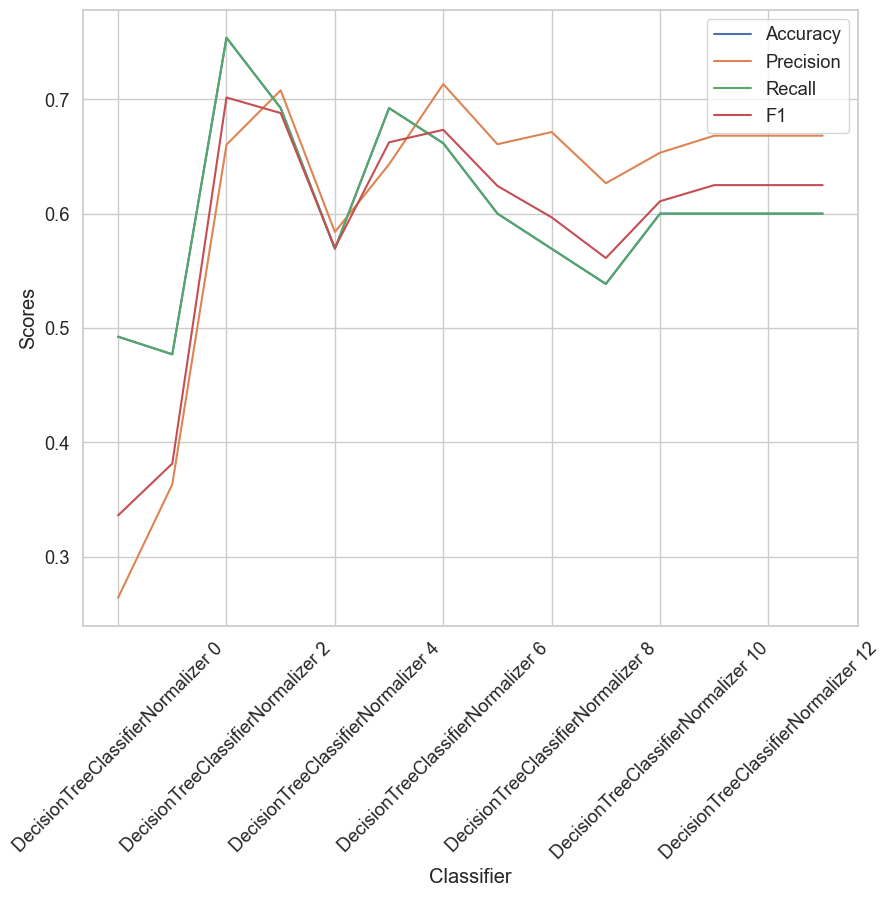

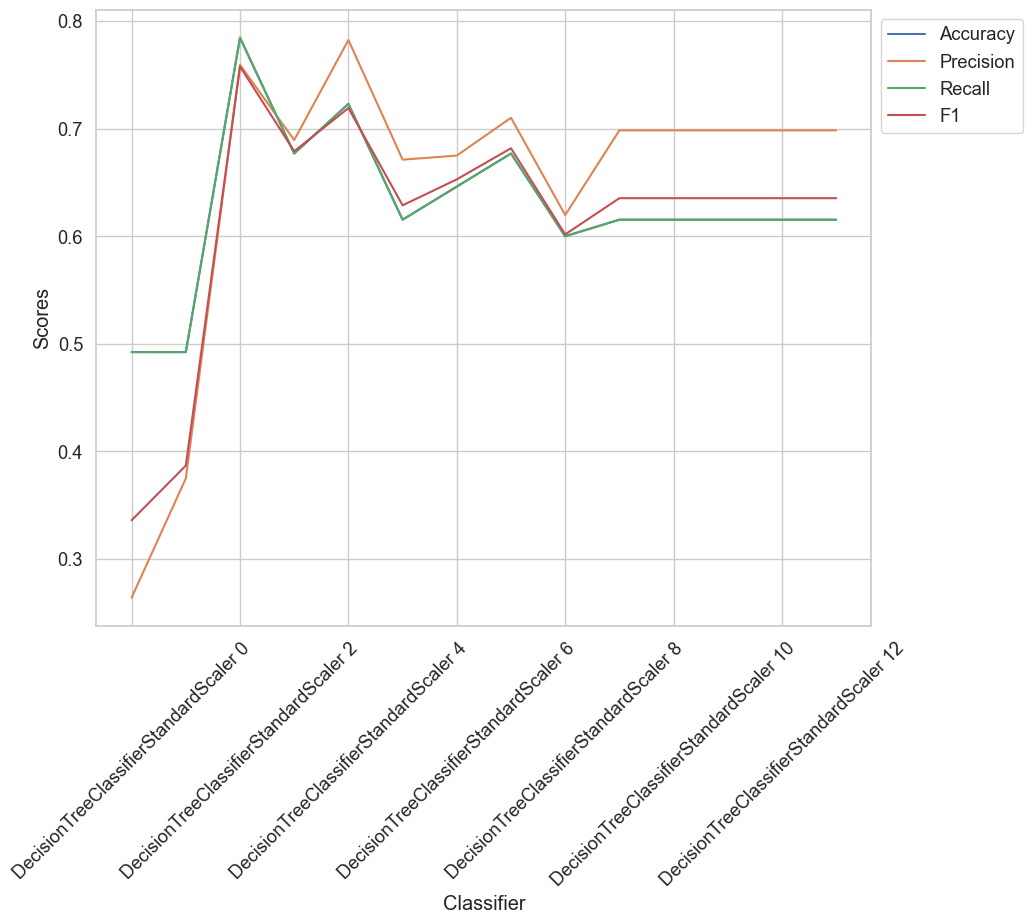

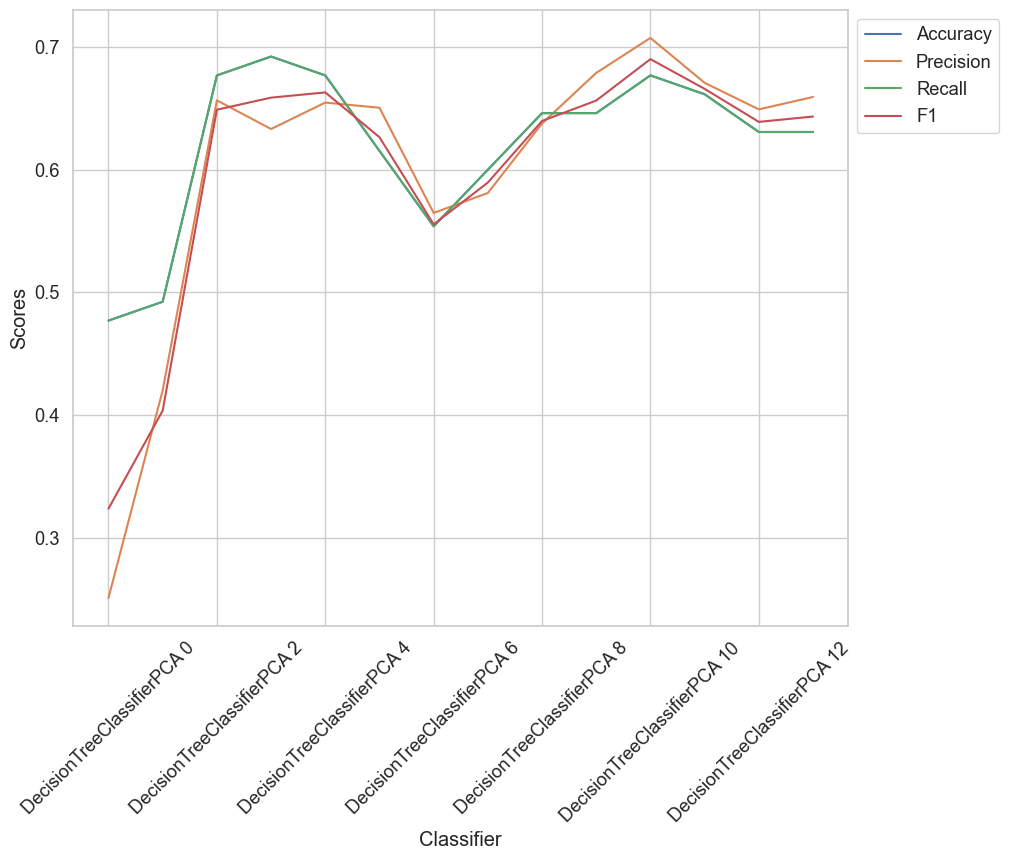

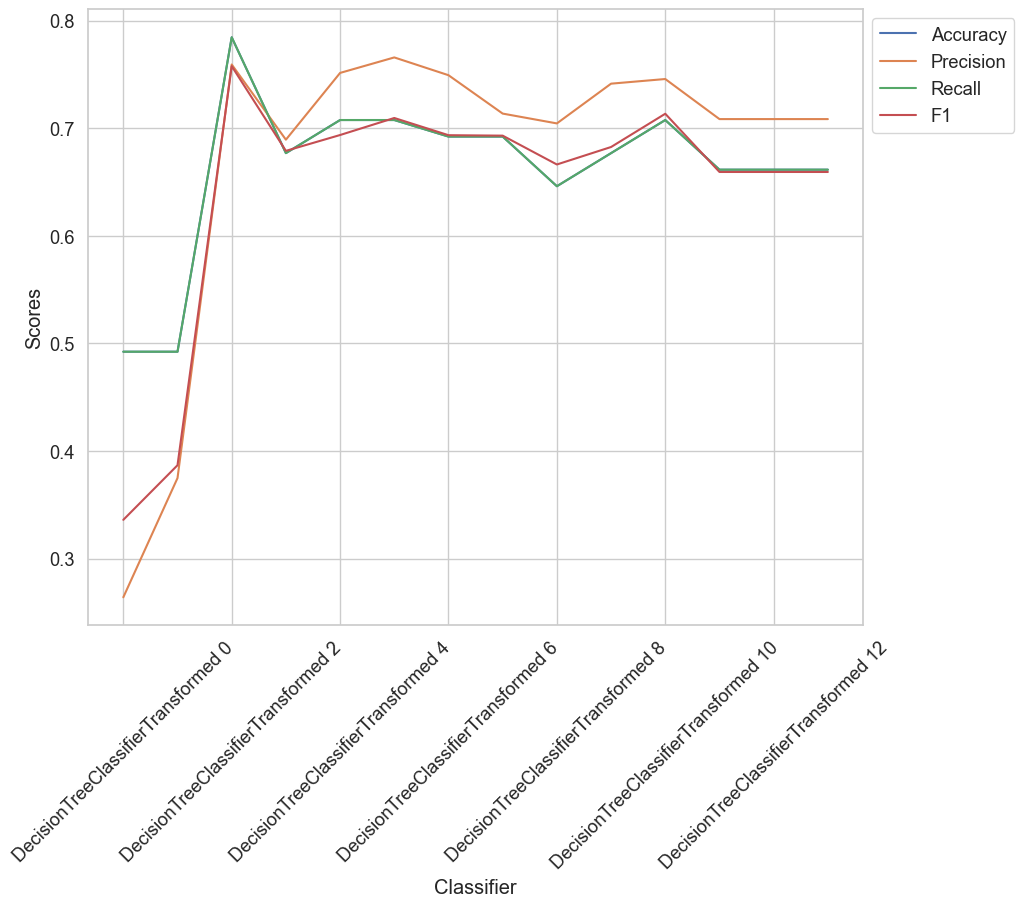

In [141]:
# iterate over DT classifiers
dt_params = [
    {'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy'},
    {'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy'},
    {'max_depth': 4, 'min_samples_split': 10, 'criterion': 'entropy'},
    {'max_depth': 10, 'min_samples_split': 10, 'criterion': 'entropy'},
]
# create a list od dt_params in loop of max depth = 0 to 30 
dt_params = []
for i in range(1, 15):
    dt_params.append({'max_depth': i, 'min_samples_split': 2, 'criterion': 'gini'})

dt_classifiers = dt_classifiers_create(dt_params)
iterate_classifiers(dt_classifiers)

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  4
Best iteration:  0


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  4
Best iteration:  21


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

Best iteration:  0


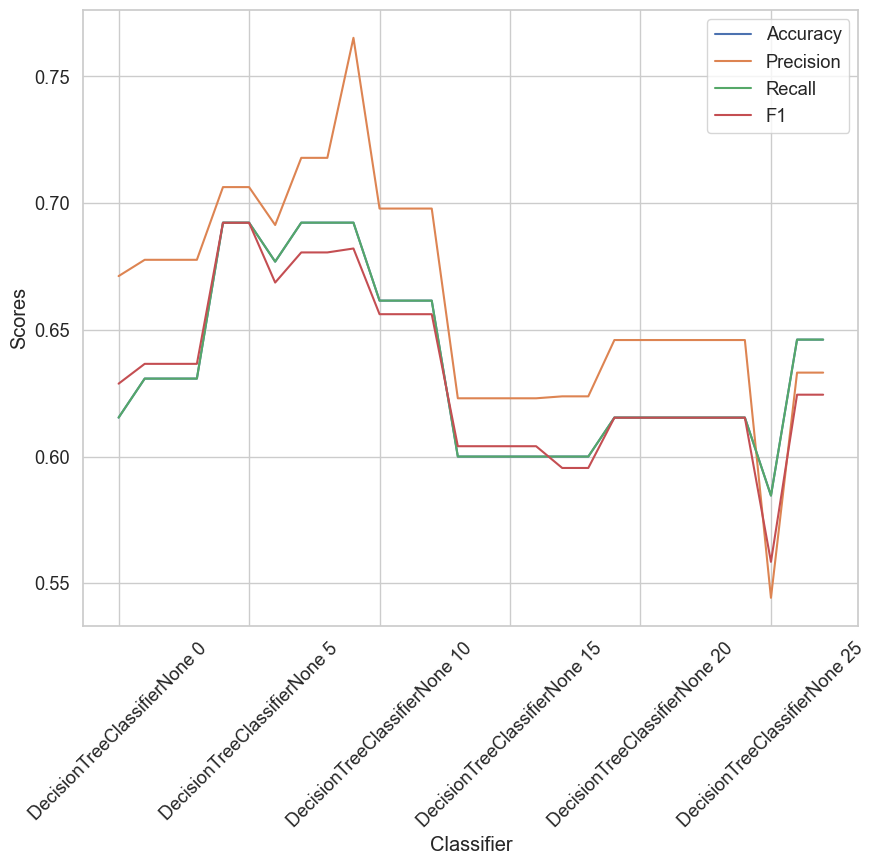

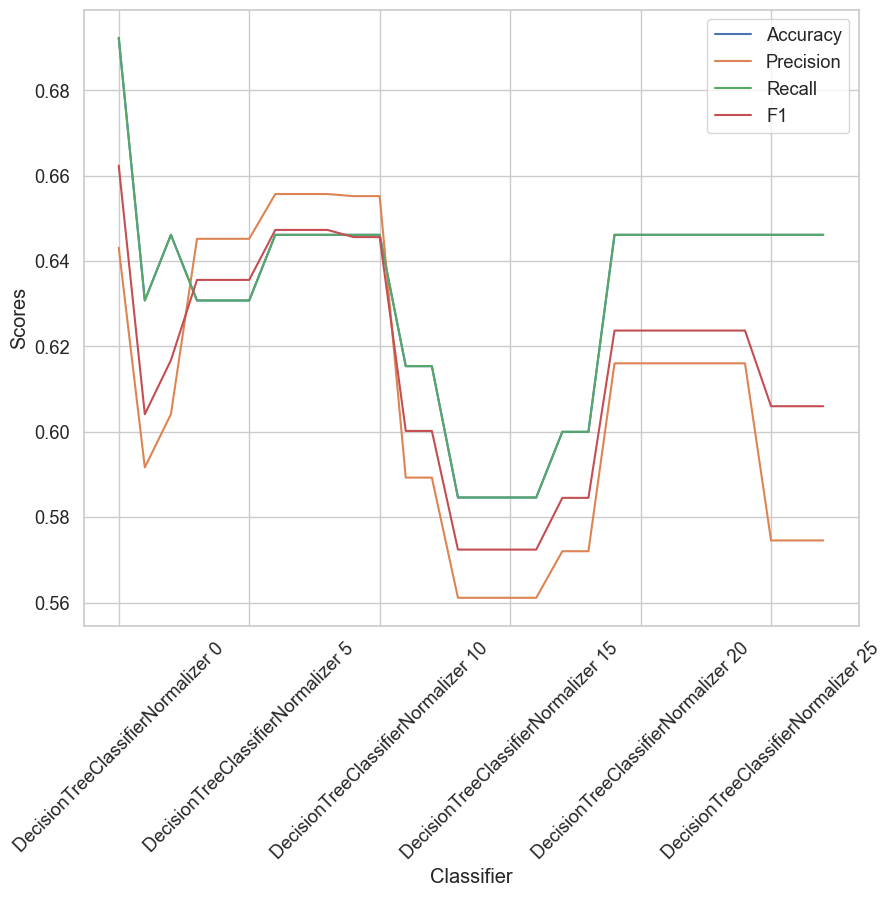

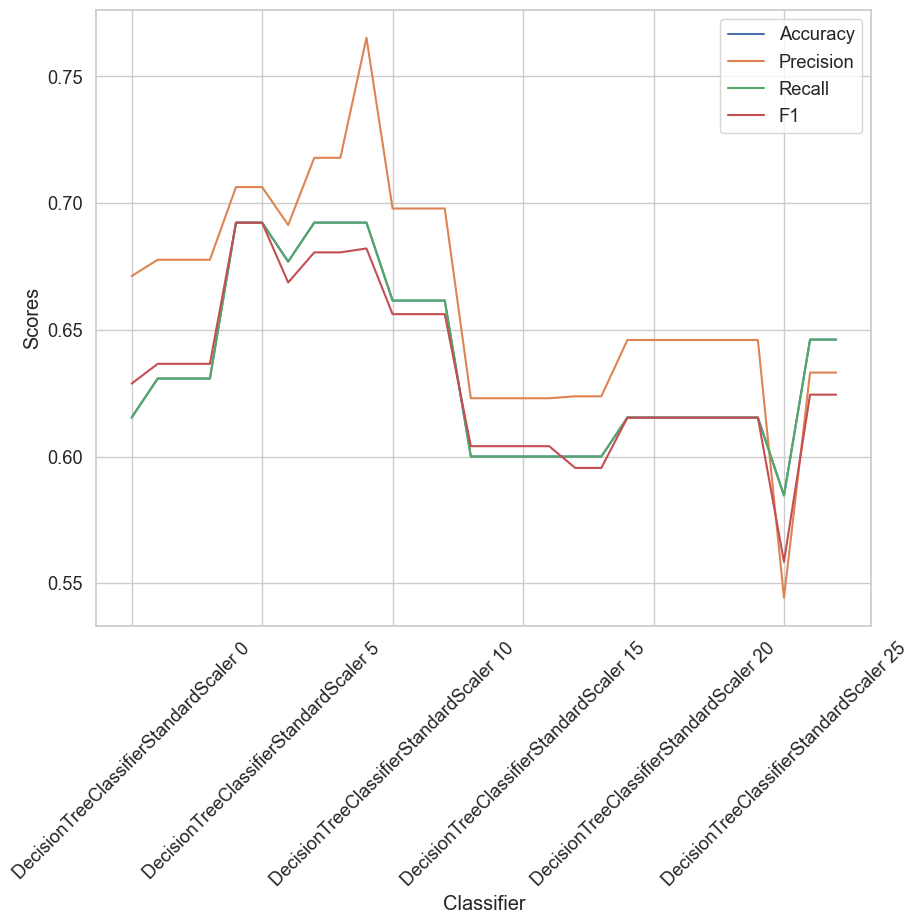

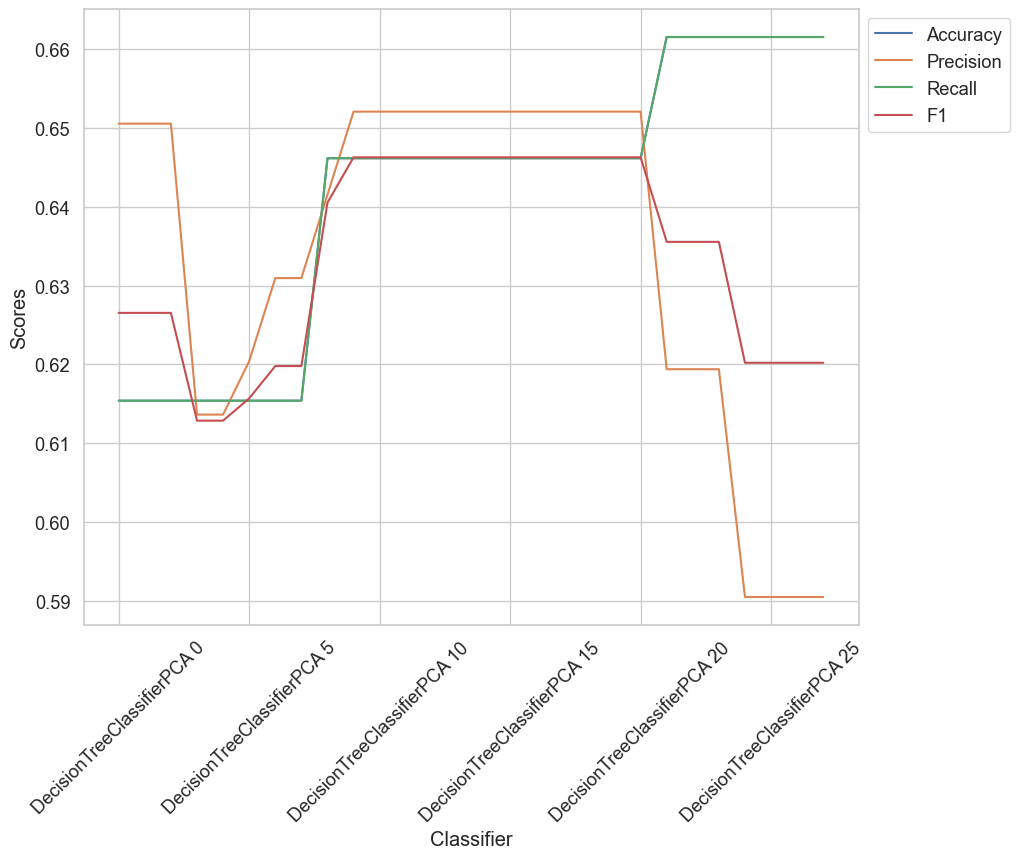

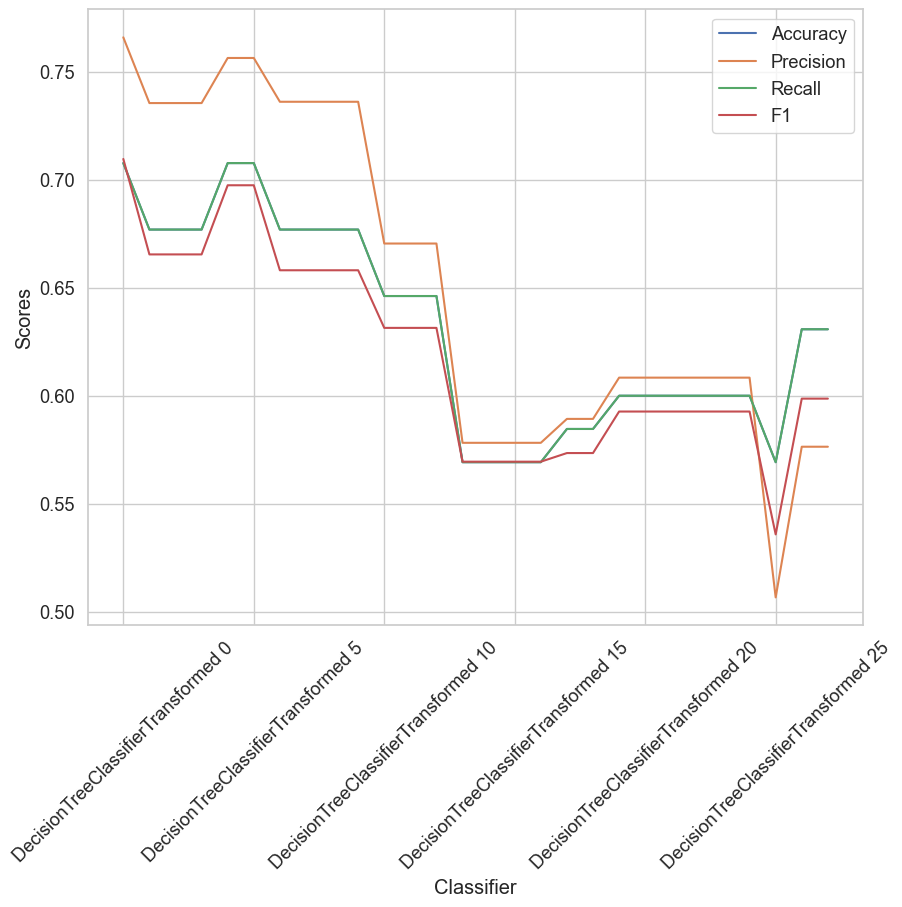

In [140]:
dt_params = []
for i in range(2, 30):
    dt_params.append({'max_depth': 6, 'min_samples_split': i, 'criterion': 'gini'})

dt_classifiers = dt_classifiers_create(dt_params)
iterate_classifiers(dt_classifiers)

ocena klasyfikacji – do porównania wyników różnego typu przygotowania danych oraz wykorzystanego klasyfikatora użyj poznanych metryk oceny klasyfikacji i zinterpretuj wyniki.



In [ ]:
# get standarized data and pca data, create a classfiier of nb and dt give them best hiperparameters and compare results
# NB
nb = GaussianNB(var_smoothing=3.51119173e-01)
accuracy_nb, precision_nb, recall_nb, f1_nb = train_and_test_model(X_train_stand, X_val_stand, y_train_stand, y_val_stand, nb)
print('Accuracy: ', accuracy_nb)
print('Precision: ', precision_nb)
print('Recall: ', recall_nb)
print('F1: ', f1_nb)

# DT
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_split=5)
accuracy_dt, precision_dt, recall_dt, f1_dt = train_and_test_model(X_train_stand, X_val_stand, y_train_stand, y_val_stand, dt)
print('Accuracy: ', accuracy_dt)
print('Precision: ', precision_dt)
print('Recall: ', recall_dt)
print('F1: ', f1_dt)

# compare results
results = pd.DataFrame({'Accuracy': [accuracy_nb, accuracy_dt],
                        'Precision': [precision_nb, precision_dt],
                        'Recall': [recall_nb, recall_dt],
                        'F1': [f1_nb, f1_dt]},
                        index=['Naive Bayes', 'Decision Tree'])
results

# visualise it in a bar chart
results.plot(kind='bar', figsize=(10, 8))
plt.title('Naive Bayes vs Decision Tree')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))



In [ ]:
# iterate over NB classifiers
nb_params = np.logspace(0, -9, num=100)
nb_classifiers = nb_classifiers_create(nb_params)
print('Naive Bayes')
iterate_classifiers(nb_classifiers, X_train_pca, X_val_pca, y_train_pca, y_val_pca)

In [ ]:
# iterate over DT classifiers
dt_params = [
    {'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy'},
    {'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy'},
    {'max_depth': 4, 'min_samples_split': 10, 'criterion': 'entropy'},
    {'max_depth': 10, 'min_samples_split': 10, 'criterion': 'entropy'},
]

dt_classifiers = dt_classifiers_create(dt_params)
iterate_classifiers(dt_classifiers, X_train_pca, X_val_pca, y_train_pca, y_val_pca)

In [ ]:
# get standarized data and pca data, create a classfiier of nb and dt give them best hiperparameters and compare results
# NB
nb = GaussianNB(var_smoothing=8.11130831e-01)
accuracy_nb, precision_nb, recall_nb, f1_nb = train_and_test_model(X_train_pca, X_val_pca, y_train_pca, y_val_pca, nb)
print('Accuracy: ', accuracy_nb)
print('Precision: ', precision_nb)
print('Recall: ', recall_nb)
print('F1: ', f1_nb)

# DT
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=5)
accuracy_dt, precision_dt, recall_dt, f1_dt = train_and_test_model(X_train_pca, X_val_pca, y_train_pca, y_val_pca, dt)
print('Accuracy: ', accuracy_dt)
print('Precision: ', precision_dt)
print('Recall: ', recall_dt)
print('F1: ', f1_dt)

# compare results
results = pd.DataFrame({'Accuracy': [accuracy_nb, accuracy_dt],
                        'Precision': [precision_nb, precision_dt],
                        'Recall': [recall_nb, recall_dt],
                        'F1': [f1_nb, f1_dt]},
                        index=['Naive Bayes', 'Decision Tree'])
results

# visualise it in a bar chart
results.plot(kind='bar', figsize=(10, 8))
plt.title('Naive Bayes vs Decision Tree')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.0, 1.0))

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

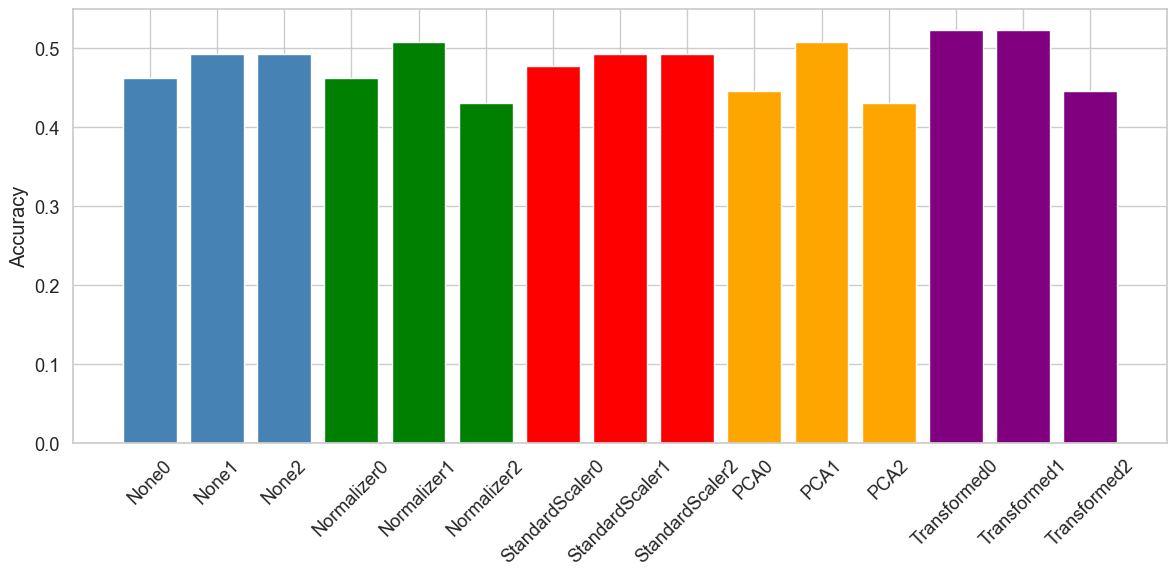

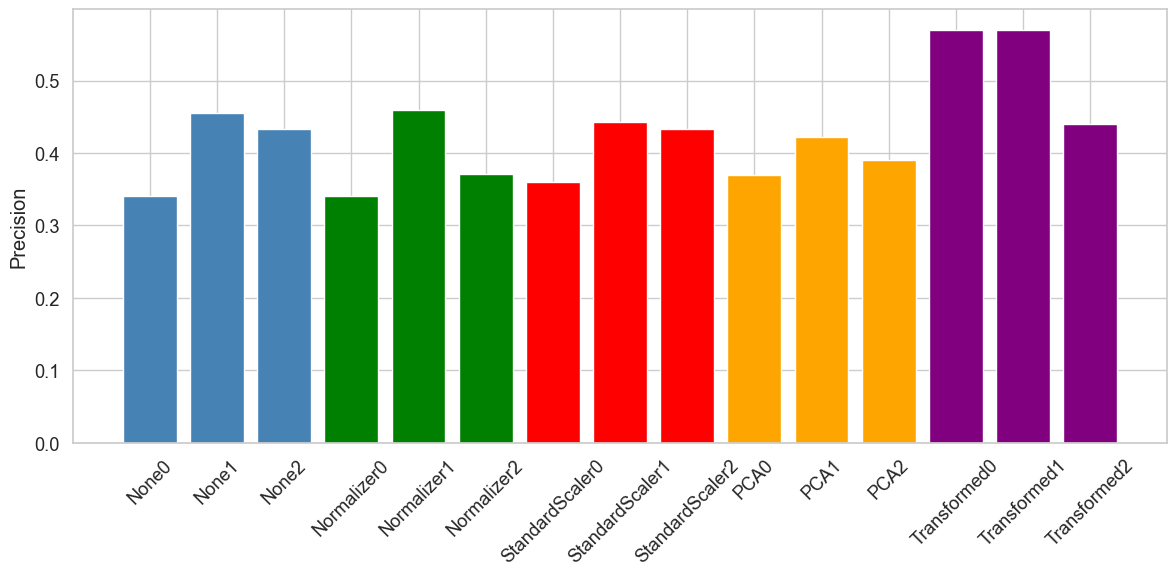

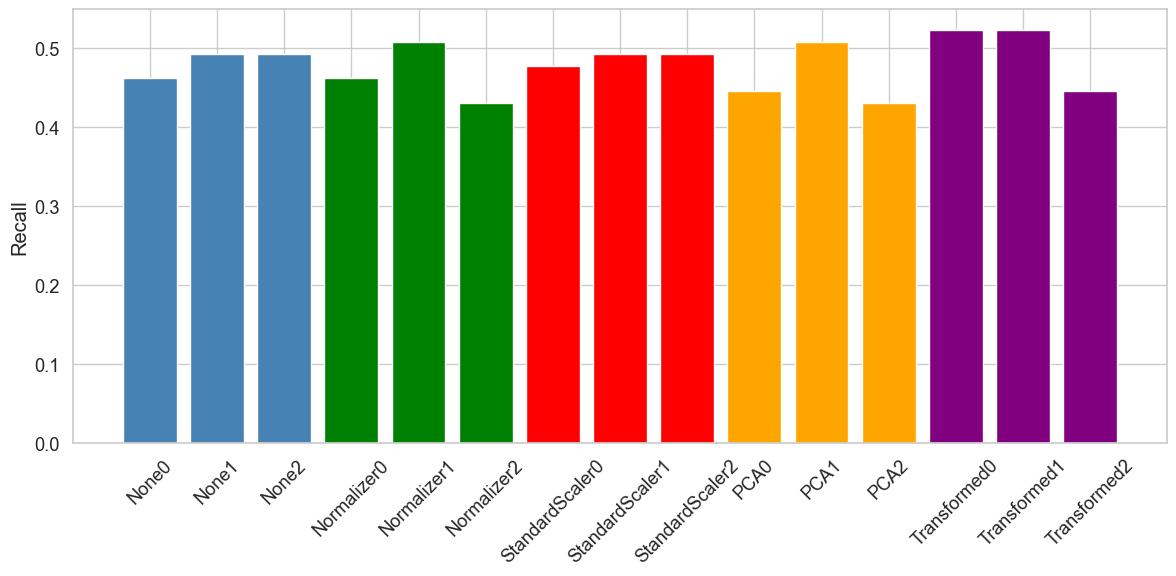

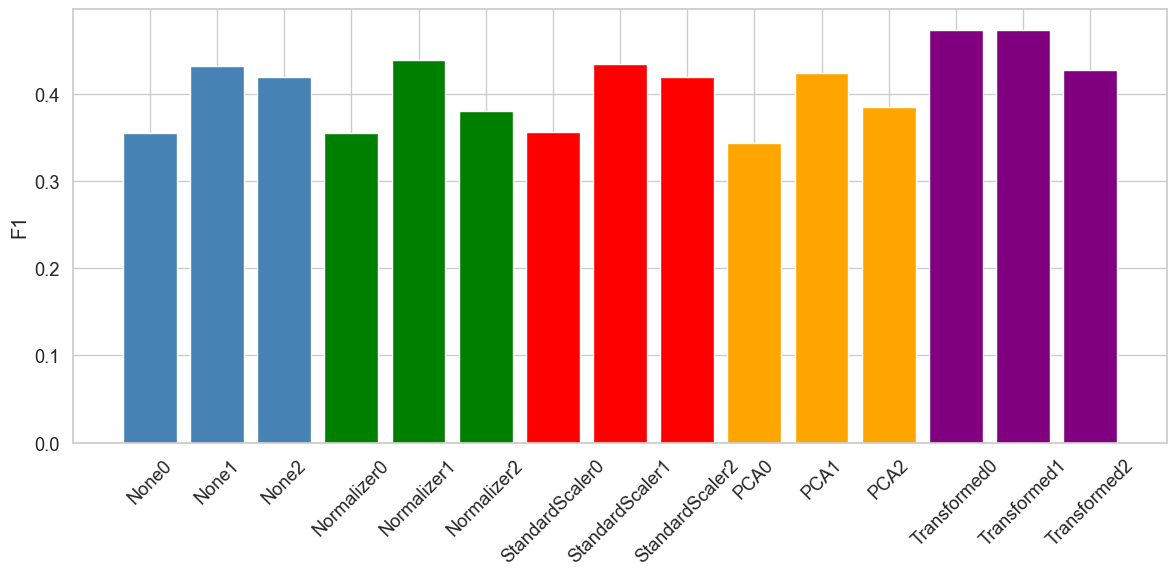

In [157]:


def show_table(title, results):
    print("\n\n\n")
    print("Klasyfikator   " + title + "     | Dokladnosc Precyzja   Czulosc  F1-score  |")
    print("-" * 70)
    for row in results:
        print("{:20s}  |  {:.6f}  {:.6f}  {:.6f}  {:.6f}  |".format(row[0], row[1], row[2], row[3], row[4]))

# create a dictionary of nb_params for eachg processing method

var_smoothng_list =  np.logspace(0, -9, num=100)
# get first value of var_smoothng_list
var_smoothng_list[0]
# get last value of var_smoothng_list
var_smoothng_list[-1]

nb_params_dict = {
    'None': [var_smoothng_list[0],var_smoothng_list[11],var_smoothng_list[-1]],
    'Normalizer': [var_smoothng_list[0],var_smoothng_list[10],var_smoothng_list[-1]],
    'StandardScaler': [var_smoothng_list[0],var_smoothng_list[9],var_smoothng_list[-1]],
    'PCA': [var_smoothng_list[0],var_smoothng_list[10],var_smoothng_list[-1]],
    'Transformed' : [var_smoothng_list[0],var_smoothng_list[0],var_smoothng_list[-1]]
}

def create_classifiers_for_processed_data(nb_params):
    nb_classifiers = []
    
    for param in nb_params:
        nb = GaussianNB(var_smoothing=param)
        nb_classifiers.append(nb)

    return nb_classifiers
        

def run_nb():
    results = []

    for name, X_processed_train, X_processed_val, y_processed_train, y_processed_val in processing():
        for i, classifier in enumerate(create_classifiers_for_processed_data(nb_params_dict[name])):
            row = [name + str(i)]
            accuracy, precision, recall, f1 = train_and_test_model(X_processed_train, X_processed_val, y_processed_train, y_processed_val, classifier)
            row.extend([accuracy, precision, recall, f1])
            results.append(row)
    return results

# create list of names of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']


def plot_results(results, nr):
    plt.figure(figsize=(12, 6))
    scores = [row[nr] for row in results]
    hyperparameters = [row[0] for row in results]
    
    # Define a color palette
    colors = ['steelblue'] * 3 + ['green'] * 3 + ['red'] * 3 + ['orange'] * 3 + ['purple'] * 3
    
    # Plot the results with the corresponding colors
    plt.bar(hyperparameters, scores, color=colors)
    
    plt.ylabel(str(metrics[nr-1]))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



nb_results = run_nb()


# show_table('NB', nb_results)

# visualize results in a table



for i in range(1, 5):
    plot_results(nb_results, i)


In [137]:
pd.DataFrame(nb_results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1'])

,Classifier,Accuracy,Precision,Recall,F1
0,None0,0.461538,0.341132,0.461538,0.354913
1,None1,0.492308,0.455000,0.492308,0.431603
2,None2,0.492308,0.432652,0.492308,0.418980
3,Normalizer0,0.461538,0.341132,0.461538,0.354913
4,Normalizer1,0.507692,0.459114,0.507692,0.438654
5,Normalizer2,0.430769,0.371331,0.430769,0.380155
6,StandardScaler0,0.476923,0.359994,0.476923,0.356231
7,StandardScaler1,0.476923,0.359994,0.476923,0.356231
8,StandardScaler2,0.492308,0.432652,0.492308,0.418980
9,PCA0,0.446154,0.370034,0.446154,0.343829


ogranicz ilosc zestawów hiperparametrów do 3.


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: 

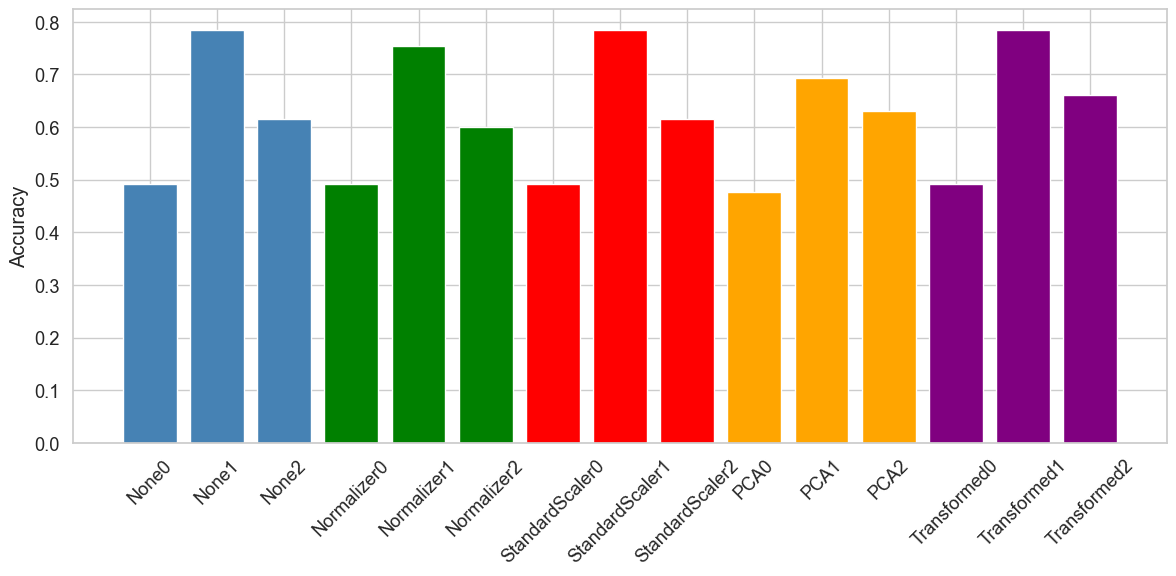

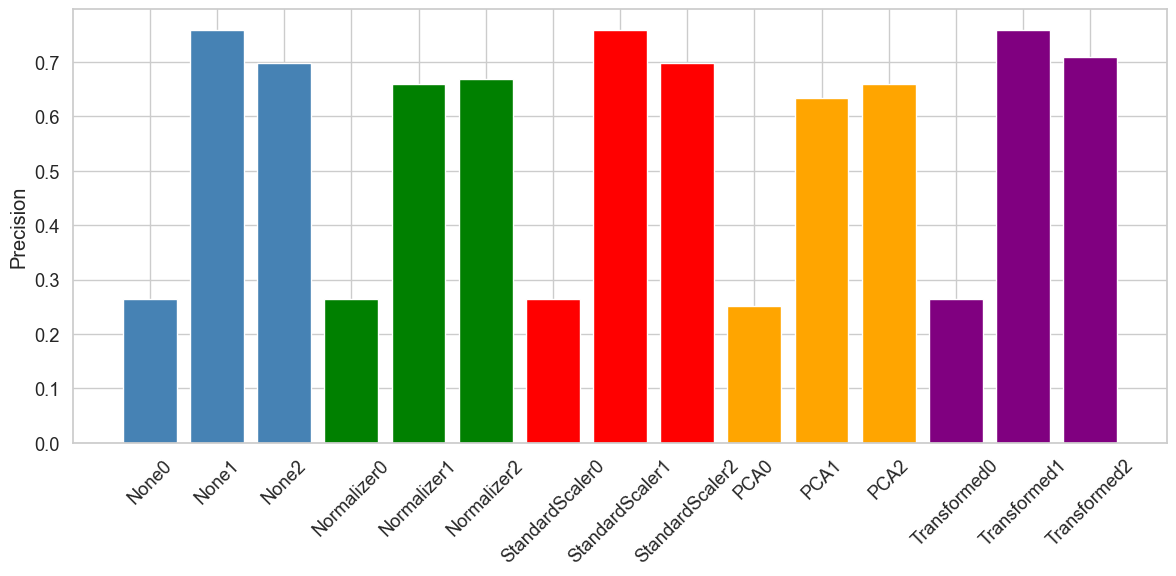

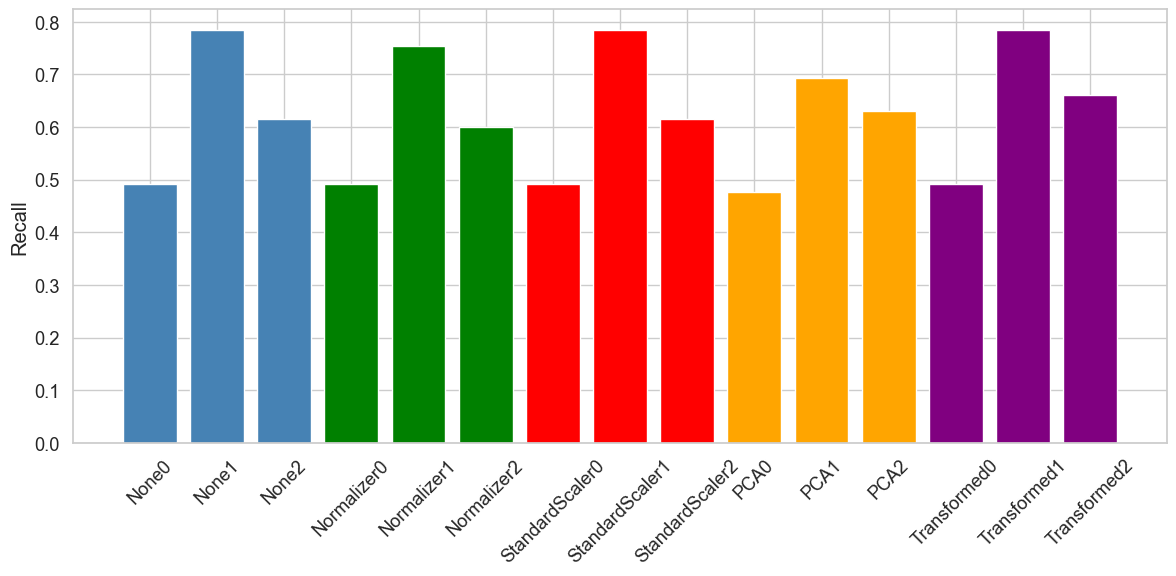

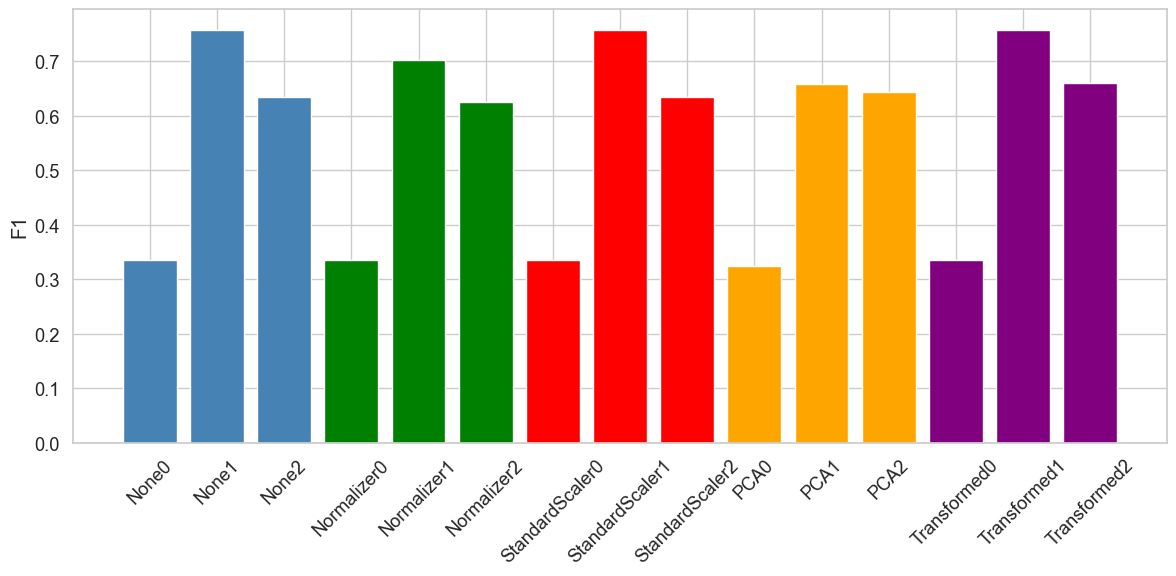

In [156]:
dt_params = []
for i in range(1, 15):
    dt_params.append({'max_depth': i, 'min_samples_split': 2, 'criterion': 'gini'})

dt_params_dict = {
    'None': [dt_params[0],dt_params[2],dt_params[-1]],
    'Normalizer': [dt_params[0],dt_params[2],dt_params[-1]],
    'StandardScaler': [dt_params[0],dt_params[2],dt_params[-1]],
    'PCA': [dt_params[0],dt_params[3],dt_params[-1]],
    'Transformed' : [dt_params[0],dt_params[2],dt_params[-1]]
}

def create_classifiers_for_processed_data_dt(params):
    dt_classifiers = []
    for params in params:
        dt = DecisionTreeClassifier(criterion=params.get('criterion'), max_depth=params.get('max_depth'),
                                    min_samples_split=params.get('min_samples_split'), random_state=0)
        dt_classifiers.append(dt)

    return dt_classifiers
        

def run_dt():
    results = []

    for name, X_processed_train, X_processed_val, y_processed_train, y_processed_val in processing():
        for i, classifier in enumerate(create_classifiers_for_processed_data_dt(dt_params_dict[name])):
            row = [name + str(i)]
            accuracy, precision, recall, f1 = train_and_test_model(X_processed_train, X_processed_val, y_processed_train, y_processed_val, classifier)
            row.extend([accuracy, precision, recall, f1])
            results.append(row)
    return results

# create list of names of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# color palette for plots with the same color for the same processing method
# def plot_results(results, nr):
#     plt.figure(figsize=(12, 6))
#     scores = [row[nr] for row in results]
#     hyperparameters = [row[0] for row in results]
#     plt.bar(hyperparameters, scores)
#     plt.ylabel(str(metrics[nr-1]))
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

import seaborn as sns


def plot_results(results, nr):
    plt.figure(figsize=(12, 6))
    scores = [row[nr] for row in results]
    hyperparameters = [row[0] for row in results]
    
    # Define a color palette
    colors = ['steelblue'] * 3 + ['green'] * 3 + ['red'] * 3 + ['orange'] * 3 + ['purple'] * 3
    
    # Plot the results with the corresponding colors
    plt.bar(hyperparameters, scores, color=colors)
    
    plt.ylabel(str(metrics[nr-1]))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




dt_results = run_dt()


# show_table('NB', nb_results)

# visualize results in a table



for i in range(1, 5):
    plot_results(dt_results, i)